# GM based car following model

In [1]:
#import all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import math

Read the excel sheet and extract the dataset <br>
Following statement should be used to filter a particular leader-follower pair from the dataset <br>
```df_filter = df.groupby("LF_pair").get_group(1)```

In [2]:
df = pd.read_excel("Dataset.xlsx")
print(df)

      LF_pair VehicleID        Time   Position      Speed  Acceleration
0           1    Bike_1   35.733333  50.192392  13.815458      0.227008
1           1    Bike_2   35.733333  61.456807  14.199668     -0.361772
2           1    Bike_1   35.766667  49.689652  13.804018      0.223941
3           1    Bike_2   35.766667  60.983469  14.201858     -0.264244
4           1    Bike_1   35.800000  49.205511  13.790835      0.220522
...       ...       ...         ...        ...        ...           ...
1201        9    Car_16  846.500000  20.027389  18.713463      0.009891
1202        9    Car_15  846.533333   1.192230  14.525861     -0.087009
1203        9    Car_16  846.533333  19.412521  18.779009      0.008472
1204        9    Car_15  846.566667   0.725796  14.535505     -0.088380
1205        9    Car_16  846.566667  18.803432  18.838735      0.006855

[1206 rows x 6 columns]


So the Data that we need is<br> 1) Leader : - Time stamp; Velocity; Position; acceleration<br>
2) Follower : - Time Stamp; Velocity; Position<br>
We will calculate the acceleration of the follower based on the above parameters using the following formula

$\\ \ddot{x}_{n+1}(t + \Delta t) = \{ \frac{\alpha(l,m)(\dot{x}_{n+1}(t + \Delta t))^m}{(x_{n}(t) - x_{n+1}(t))^l}\}[\dot{x}_{n}(t) - \dot{x}_{n+1}(t)] $

### Load the training dataset

In [3]:
x_train = [df.iloc[::2] , df.iloc[1::2, :-1]] # This contains the input parameters
Y_train = df.iloc[1::2, -1] # this contains the acceleration of the follower after time delT

### Load the input data from the training dataframe

In [4]:
follower_s_t1 = x_train[1].iloc[:, 3]
follower_v_t1 = x_train[1].iloc[:-1, 4]
follower_v_t2 = x_train[1].iloc[1:, 4]
leader_s_t1 = x_train[0].iloc[:, 3]
leader_v_t1 = x_train[0].iloc[:-1, 4]

# Since the 1-Dimensional dataframes for the input values are not of equal shapes we have to account for the missing value
# here I used the averaging method to fill out all the sinks
follower_v_t1[114] = follower_v_t1.mean()
follower_v_t2[114] = follower_v_t2.mean()
leader_v_t1[115] = leader_v_t1.mean()


Compile all the 1D dataframes into a python nd array

In [5]:
X_train = np.array([[follower_v_t2],[ leader_s_t1], [follower_s_t1],[leader_v_t1],[follower_v_t1]])
X_train.shape

(5, 1, 603)

### Define the equation to estimate the accleration of the following vehicle

In [6]:
def carFollowingEquation1(X_train, a, l, m):
    follower_a_t2 = np.multiply(np.divide((a*(np.power(X_train[0][0][:],m))),np.power(np.subtract(X_train[2][0][:], X_train[1][0][:]),l)),np.subtract(X_train[3][0][:], X_train[4][0][:]))
    return follower_a_t2

### Define the gradient function

In [7]:
def gradient_function(X, y, params):
    y_pred = carFollowingEquation1(X, *params)
    grad = np.zeros(len(params))
    for i in range(len(params)):
        if i == 0:
            grad[i] = np.mean(2 * np.multiply((X[0]**params[2] / (np.subtract(X[2],X[1]))**params[1]) * (np.subtract(X[3],X[4])), np.broadcast_to((y_pred - y), (603, ))))
        elif i == 1:
            grad[i] = np.mean(2 * np.multiply((((params[0]*X[0]**params[2])*np.log((np.subtract(X[2],X[1])) + 0.00001)*(np.subtract(X[3],X[4]))) / (np.subtract(X[2],X[1]))**(params[1]+1)), np.broadcast_to((y - y_pred), (603, ))))
        elif i == 2:
            grad[i] = np.mean(2 * np.multiply((params[0]*X[0]**params[2] * np.log(X[0] + 0.00001)) / (np.subtract(X[2],X[1]))**params[1] * (np.subtract(X[3],X[4])),np.broadcast_to((y_pred - y), (603, ))))
    return grad

### Define the cost function
Here we compute the cost of the equation based on an intermediate value of the parameters
our aim is to minimize the cost

In [8]:
def cost_function(X, y, params):
    y_pred = carFollowingEquation1(X, *params)
    cost = np.mean((y_pred - y)**2)
    return cost

### Define the gradient descent function
Now its time to apply the gradient descent algorithm
we use backward propagation to estimate the gradients and then update the gradients as
learning rate times the partial derivative of the cost function wrt the parameter

In [40]:
def gradient_descent(X, y, params, learning_rate, max_epochs):
    # Perform gradient descent
    cache = []
    epoch = []
    for i in range(max_epochs):
        grad = gradient_function(X, y, params)
        params -= learning_rate * grad
        cost = cost_function(X, y, params)
        cache.append(cost)
        epoch.append(i)
        # Print the cost every 10 epochs
        if i % 5 == 0:
            print(f"Epoch {i}, Cost: {cost:.4f}")
        
    return params, cache, epoch

### Compile all parts of the model
Initialize the parameters purely user based hence can be modified

Parameters: [-0.04872808  0.61655933  0.65265641]


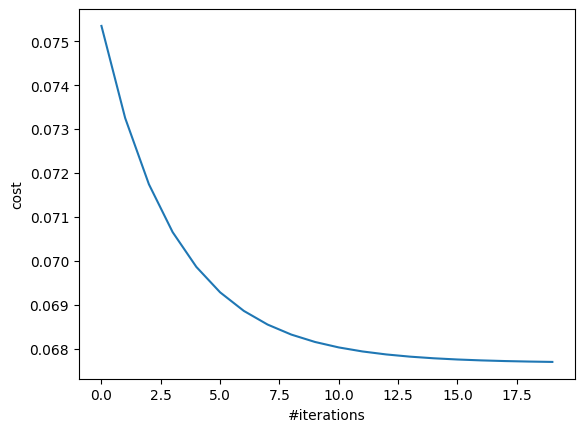

In [46]:
params = np.array([0.3, 0.6, 1], dtype = float)

# Set the hyperparameters
learning_rate = 0.01
max_epochs = 20

# Apply the Gradient descent
parameters, cache, epoch = gradient_descent(X_train, Y_train, params, learning_rate, max_epochs)

#Get the parameters
print(f"Parameters: {parameters}")

#plot the graph of the cost function wrt number of iterations
plt.plot(epoch, cache)
plt.xlabel('#iterations')
plt.ylabel('cost')
plt.show()